In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer


In [2]:
train = pd.read_csv("C:\\Users\\pc\\Downloads\\senti\\train.csv", encoding='latin-1')
training = pd.read_csv("C:\\Users\\pc\\Downloads\\senti\\training.csv", encoding='latin-1')


# Combine the training datasets

full_train = pd.concat([train, training], ignore_index=True)
print(full_train.head())
print(full_train.info())

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  \
0  Afghanistan        38928346.0         652860.0   

In [3]:
# Check column names
print(full_train.columns)

# Check for missing values
print(full_train.isnull().sum())

# Display unique labels in the dataset
if 'label' in full_train.columns:
    print(full_train['label'].value_counts())


Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)', 'polarity of tweet ', 'id of the tweet',
       'date of the tweet', 'query', 'user', 'text of the tweet '],
      dtype='object')
textID                1048572
text                  1048573
selected_text         1048573
sentiment             1048572
Time of Tweet         1048572
Age of User           1048572
Country               1048572
Population -2020      1048572
Land Area (Km²)       1048572
Density (P/Km²)       1048572
polarity of tweet       27481
id of the tweet         27481
date of the tweet       27481
query                   27481
user                    27481
text of the tweet       27481
dtype: int64


In [4]:
# Check for missing values
print(full_train.isnull().sum())

# Fill missing values in the 'text' column with an empty string
full_train['text'].fillna('', inplace=True)

# Remove duplicate rows (optional)
full_train.drop_duplicates(subset=['text'], inplace=True)


textID                1048572
text                  1048573
selected_text         1048573
sentiment             1048572
Time of Tweet         1048572
Age of User           1048572
Country               1048572
Population -2020      1048572
Land Area (Km²)       1048572
Density (P/Km²)       1048572
polarity of tweet       27481
id of the tweet         27481
date of the tweet       27481
query                   27481
user                    27481
text of the tweet       27481
dtype: int64


In [5]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Preprocess the text
full_train['clean_text'] = full_train['text'].apply(preprocess_text)

# Verify preprocessing
print(full_train[['text', 'clean_text']].head())


                                                text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                                 clean_text  
0                        id responded going  
1                   sooo sad miss san diego  
2                             boss bullying  
3                     interview leave alone  
4  sons couldnt put releases already bought  


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Use top 5000 features

# Fit and transform on training data
X_train = tfidf.fit_transform(full_train['clean_text'])

# Verify shape of the transformed data
print(X_train.shape)



(27481, 5000)


In [8]:
print(full_train.columns)


Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)', 'polarity of tweet ', 'id of the tweet',
       'date of the tweet', 'query', 'user', 'text of the tweet ',
       'clean_text'],
      dtype='object')


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(full_train['sentiment'])

# Verify encoding
print(set(full_train['sentiment']), "->", set(y_train))


{'positive', 'negative', 'neutral'} -> {0, 1, 2}


In [10]:
print(full_train['sentiment'].unique())



['neutral' 'negative' 'positive']


In [11]:
# Drop rows with missing sentiment
full_train = full_train.dropna(subset=['sentiment'])

# Optionally, handle unexpected values
valid_sentiments = ['positive', 'negative', 'neutral']  # Adjust as needed
full_train = full_train[full_train['sentiment'].isin(valid_sentiments)]


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(full_train['clean_text'])


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model
model = MultinomialNB()
model.fit(X_train_split, y_train_split)

# Evaluate the model
accuracy = model.score(X_val_split, y_val_split)
print("Validation Accuracy:", accuracy)


Validation Accuracy: 0.6421684555211934


In [14]:
full_test = pd.concat([train, training], ignore_index=True)


In [15]:
print(full_test.head())


       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  \
0  Afghanistan        38928346.0         652860.0   

In [16]:
full_test['text'] = full_test['text'].fillna('').astype(str)
full_test['clean_text'] = full_test['text'].apply(preprocess_text)



In [17]:
full_test['clean_text'] = full_test['text'].apply(preprocess_text)


In [18]:
X_test = vectorizer.transform(full_test['clean_text'])


In [19]:
y_test_pred = model.predict(X_test)


In [20]:
y_test_labels = label_encoder.inverse_transform(y_test_pred)
full_test['predicted_sentiment'] = y_test_labels


In [21]:
print(full_test['sentiment'].isnull().sum())  # Check for missing values in the 'sentiment' column


1048572


In [22]:
full_test = full_test.dropna(subset=['sentiment'])


In [23]:
full_test['sentiment'].fillna('Unknown', inplace=True)


In [24]:
full_test['sentiment'].fillna('Unknown', inplace=True)


In [25]:
full_test['sentiment'].fillna('Unknown', inplace=True)


In [26]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression(max_iter=200)


# Train the model
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler with with_mean=False
scaler = StandardScaler(with_mean=False)

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)


In [28]:
# Transform the 'sentiment' labels in the test data using the label encoder
y_test_actual = label_encoder.transform(full_test['sentiment'])


In [29]:
print(len(y_test_actual))
print(len(y_test_pred))


27481
1076053


In [30]:
y_test_pred = model.predict(X_test)  # Ensure you're predicting with X_test


In [31]:
print("Shape of y_test_actual:", y_test_actual.shape)
print("Shape of y_test_pred:", y_test_pred.shape)


Shape of y_test_actual: (27481,)
Shape of y_test_pred: (1076053,)


In [32]:
y_test_pred = y_test_pred[:len(y_test_actual)]


In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure the predicted array has the same number of samples as the actual labels
y_test_pred = y_test_pred[:len(y_test_actual)]

# Calculate accuracy
accuracy = accuracy_score(y_test_actual, y_test_pred)
print(f"Test Accuracy: {accuracy}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_actual, y_test_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_actual, y_test_pred))


Test Accuracy: 0.9027691859830428

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      7781
           1       0.88      0.92      0.90     11118
           2       0.92      0.91      0.91      8582

    accuracy                           0.90     27481
   macro avg       0.91      0.90      0.90     27481
weighted avg       0.90      0.90      0.90     27481


Confusion Matrix:
[[ 6769   811   201]
 [  398 10262   458]
 [  153   651  7778]]


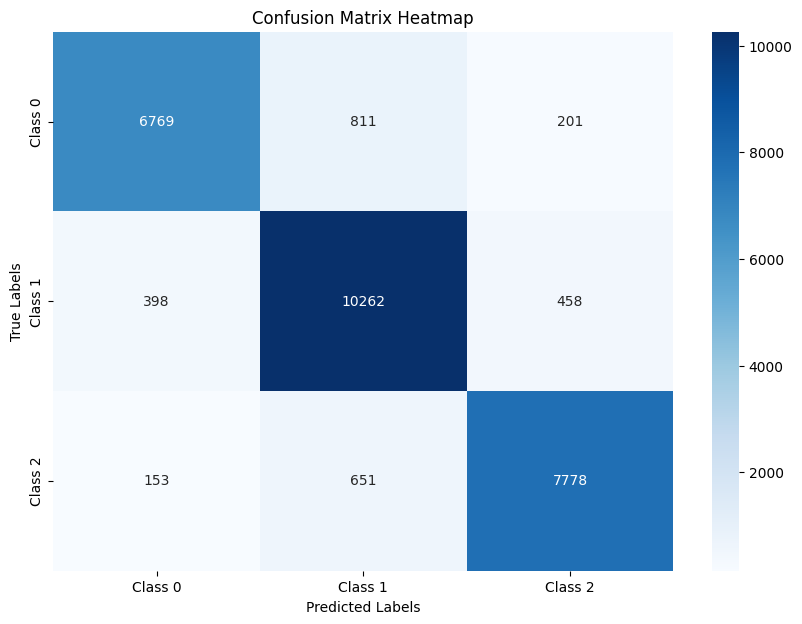

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_actual, y_test_pred)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Show the heatmap
plt.show()


In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Sample labeled data
texts = ["I love machine learning", "NLP is amazing", "I hate spam emails"]
labels = [1, 1, 0]  # 1 = positive sentiment, 0 = negative sentiment

# Vectorizing the texts
X = vectorizer.fit_transform(texts)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

In [ ]:
from transformers import pipeline

# Initialize the sentiment-analysis pipeline
classifier = pipeline("sentiment-analysis")

# Predict sentiment for some sample texts
result = classifier("I love using NLP models!")
print(result)  # Output will show positive/negative sentiment with confidence score


C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Encode input text
input_text = "Once upon a time"
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Generate text
generated_text = model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2)

# Decode the generated text
decoded_output = tokenizer.decode(generated_text[0], skip_special_tokens=True)
print(decoded_output)
